In [1]:
#Import basic tools
import numpy as np
import pandas as pd

#Import sklearn (KNN)
from sklearn.neighbors import NearestNeighbors

#Import FuzzyWuzzy for input
from fuzzywuzzy import fuzz

#Import data visualization & matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/scyaeris/.local/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#Import movies and ratings .csv files
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating
0,4,1.0,4.0
1,10,1.0,5.0
2,14,1.0,4.5
3,15,1.0,4.0
4,22,1.0,4.0


In [5]:
#The "dropna = True" parameter tells the code to ignore any entries with missing values. 
#So the code will count the number of unique users and movies in the ratings data, excluding any entries with missing values.
unique_user = ratings.userId.nunique(dropna = True)
unique_movie = ratings.movieId.nunique(dropna = True)
print(f"Number of unique users (raters): {unique_user}")
print(f"Number of unique movies: {unique_movie}")

Number of unique users (raters): 10428
Number of unique movies: 6692


In [6]:
ratings.shape

(786001, 3)

In [7]:
# In order to create item user matrixes, we need to check how many ratings exist within our dataframes/and/or how many ratings are absent
total_ratings = unique_user * unique_movie
rating_present = ratings.shape[0]

ratings_not_provided = total_ratings - rating_present 

#Implies some users have not watched some movies
print(f"Ratings not provided: {ratings_not_provided}")
print(f"Sparsity of user-item matrix is: {ratings_not_provided/total_ratings}")

Ratings not provided: 68998175
Sparsity of user-item matrix is: 0.9887366872398121


Data Exploration

In [8]:
#Gives information about which rating (on scale of 0 to 5) is more frequent
rating_cnt = pd.DataFrame(ratings.groupby('rating').size(),columns=['count'])
#This rating count does not contain any ratings of value 0

rating_cnt = rating_cnt.append(pd.DataFrame({'count' : ratings_not_provided}, index = [0])).sort_index()

#Since there are more "0 ratings" as compared to other ratings, use the log value
#Just for the visualization
rating_cnt['log_count'] = np.log(rating_cnt['count'])
rating_cnt = rating_cnt.drop(rating_cnt.index[0])
rating_cnt.head()

/tmp/ipykernel_2141/3717229656.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rating_cnt = rating_cnt.append(pd.DataFrame({'count' : ratings_not_provided}, index = [0])).sort_index()


,count,log_count
0.5,11221,9.325542
1.0,27592,10.225281
1.5,11127,9.317130
2.0,57407,10.957922
2.5,32298,10.382761


Text(0, 0.5, 'Rating Count')

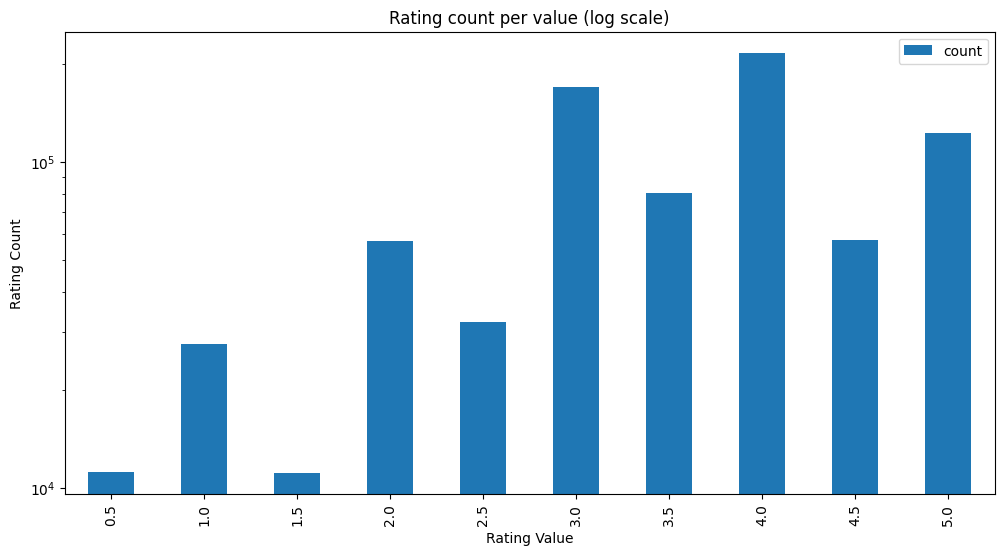

In [9]:
# Create a bar plot to visualize ratings
vis = rating_cnt
rcpv = vis.reset_index().rename(columns = {'index':'rating_value'}).plot(
    x = 'rating_value',
    y = 'count',
    logy = True,
    kind = 'bar',
    title = 'Rating count per value (log scale)',
    figsize = (12,6)
)
rcpv.set_xlabel('Rating Value')
rcpv.set_ylabel('Rating Count')

We can gather that rating values like 3.0 and 4.0 are seen more often than others

In [10]:
#Plot rating frequency of each movie (how many time a movie has been rated)
movie_freq = pd.DataFrame(ratings.groupby('movieId').size(), columns = ['count'])
movie_freq.head()

,count
movieId,
1.0,2573
2.0,1021
3.0,629
4.0,129
5.0,592


Text(0, 0.5, 'Rating frequency of movies')

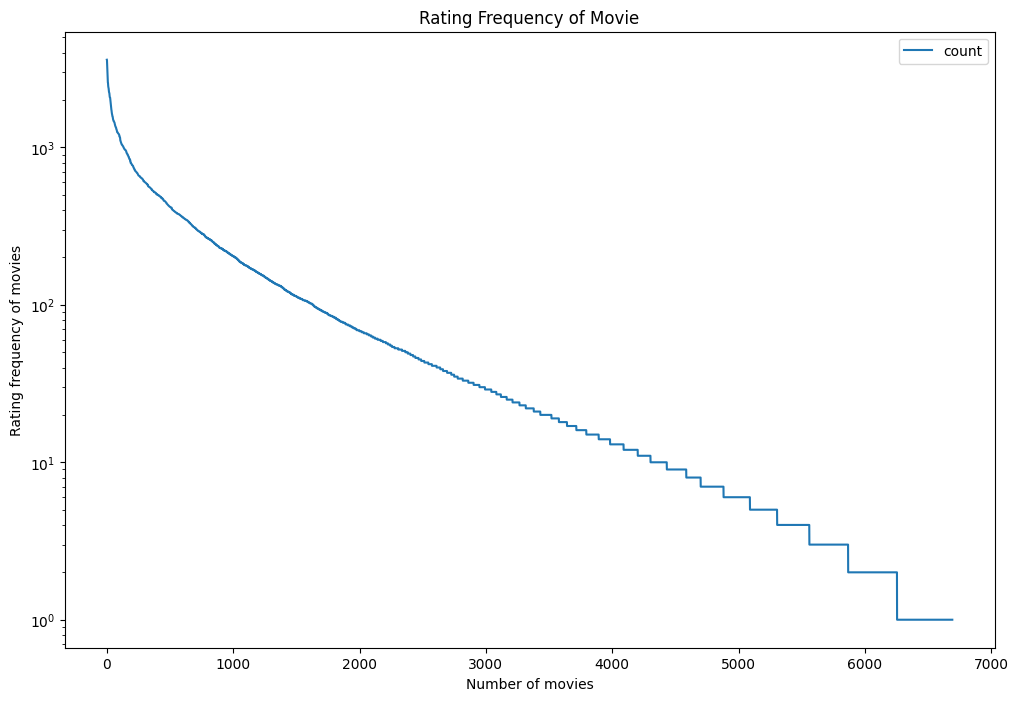

In [11]:
#Plot movie ratings by frequency
mf_copy = movie_freq.sort_values(by = 'count', ascending = False)
mf_copy = mf_copy.reset_index(drop = True)

rfpm = mf_copy.plot(
    title = 'Rating Frequency of Movie',
    logy = True,
    #Figure size (size of the graph image lol)
    figsize = (12,8)
)
rfpm.set_xlabel('Number of movies')
rfpm.set_ylabel('Rating frequency of movies')

The graph is skewed because only few movies that are popular get the most ratings. 

We can see that most movies do not have a lot of ratings.

In [12]:
threshold_rating_freq = 50
#Take out the movie IDs for which each movie is rated more than threshold value 
#Then, keep only the movies in our original ratings dataframe

popular_movies_id = list(set(movie_freq.query('count >= @threshold_rating_freq').index))

#Ratings dataframe after dropping "non-popular" movies
ratings_with_popular_movies = ratings[ratings.movieId.isin(popular_movies_id)]

print(f'Shape of Ratings: {ratings.shape}')
print(f"Number of movies that are rated more than 50 times: {len(popular_movies_id)}")
print(f"Number of unique movies present in dataset: {unique_movie}")

Shape of Ratings: (786001, 3)
Number of movies that are rated more than 50 times: 2382
Number of unique movies present in dataset: 6692


User Analysis

In [13]:
#How many times each user (userId) rates movies
user_cnt = pd.DataFrame(ratings.groupby('userId').size(),columns = ['count'])
uc_copy = user_cnt
uc_copy.head()

,count
userId,
1,16
2,15
3,11
4,640
5,35


Text(0, 0.5, 'Rating Frequency')

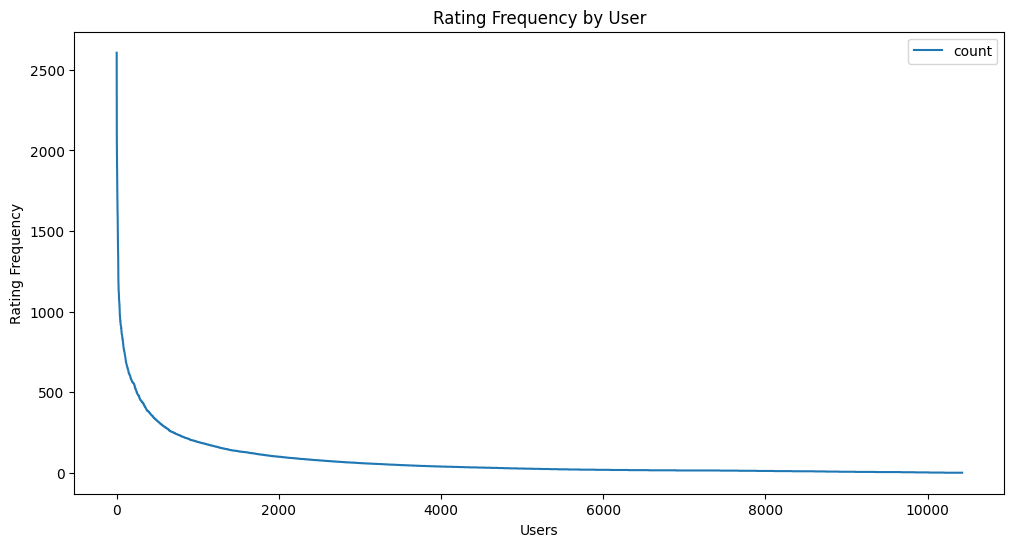

In [14]:
#Creates a bar graph that displays the rating frequency of each user. 
#Sorts the data in descending order and labels the x-axis as "Users" and the y-axis as "Rating Frequency". 
#The title of the graph is "Rating Frequency by User". 
#The figure size is set to 12 by 6.
rfpu = uc_copy.sort_values('count',ascending = False).reset_index(drop = True).plot(
      title = 'Rating Frequency by User',
      figsize = (12,6),
)
rfpu.set_xlabel("Users")
rfpu.set_ylabel("Rating Frequency")

Rating Frequency by User follows tail trend: generally there are just fewer users who are interseted in rating movies

There are few users that only avidly rate movies

In [15]:
# Lets find users who have more than 30 ratings
threshold_val = 30
active_user = list(set(user_cnt.query('count >= @threshold_val').index))

#update your ratings_with_popular_movies
ratings_with_popular_movies_with_active_user = ratings_with_popular_movies[ratings_with_popular_movies.userId.isin(active_user)]

print(f'Shape of ratings_with_popular_movies: {ratings_with_popular_movies.shape}')
print(f'Shape of ratings_with_popular_movies_with_active_user: {ratings_with_popular_movies_with_active_user.shape}')
print(f"Unique users: {unique_user}")
print(f"Unique movies: {unique_movie}")
print(f"Popular movies: {len(popular_movies_id)}")

Shape of ratings_with_popular_movies: (728384, 3)
Shape of ratings_with_popular_movies_with_active_user: (655566, 3)
Unique users: 10428
Unique movies: 6692
Popular movies: 2382


In [16]:
print(f"Sparsity of final dataframe ratings: {(unique_user*unique_movie - ratings_with_popular_movies.shape[0])/(unique_user*unique_movie)}")

Sparsity of final dataframe ratings: 0.9895623328704204


Sparsity reduced by removing unpopular movies and inactive users who only reviewed a select amount of movies

#Building KNN Model

We have to reshape/prepare our dataset into a format which can be given as parameter to the KNN function. We will pivot our final dataset into a ITEM-USER matrix and fill empty cells with with the vlaue 0 because the KNN model calculates distances between two points. 

In [17]:
#final_ratings is a dataframe with the ratings of the movies that are popular and the users that are active
#item_user_mat is a matrix with the movies as rows and the users as columns. The values are the ratings.
#If there is no rating, the value is 0.
final_ratings = ratings_with_popular_movies_with_active_user
item_user_mat = final_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
item_user_mat.head()

userId,4,5,6,8,10,14,15,16,18,19,...,10517,10518,10519,10524,10526,10527,10529,10530,10531,10532
movieId,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,0.0,0.0,0.0,5.0,4.5,4.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,3.5,0.0,0.0,5.0,0.0
2.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Creates a dictionary called movie_to_index, with the movie titles as keys and the numerical index as values. 
#It does this by enumerating the movie titles from the list of movies and setting the index to the movieId values from the item_user_mat.
movie_to_index = {
    movie:i for i, movie in enumerate(list(movies.set_index('movieId').loc[item_user_mat.index].title))
}

In [19]:
#Creates a sparse matrix from the item_user_mat matrix. 
#A sparse matrix is a data structure that only stores the nonzero elements of a matrix, thus saving memory. 
#The csr_matrix() function is used to create a Compressed Sparse Row matrix from the values of the item_user_mat matrix.
item_user_mat_sparse = csr_matrix(item_user_mat.values)

When a movie name is given as input we need to find that movie in our dataset. If it is not present then we can not recommend anything. 


In [20]:
#"find" function will find the closest matching string from a given set of strings. 
#The input_str is a string the user is searching for, and mapper is a set of strings. 
#The code searches through the set of strings and uses fuzz.ratio to compare the input_str to the strings in mapper. 
#If the ratio is greater than or equal to 50, it is added to the match_movie list. 
#The list is then sorted by the ratio in decreasing order and the index of the highest ratio is returned. 
#If no match is found, -1 is returned.

def find(input_str, mapper):
    #match_movie is list of tuples, which have 3 values (movie_name, index, fuzz_ratio)
    match_movie = []
    for movie, ind in mapper.items():
        current_ratio = fuzz.ratio(movie.lower(), input_str.lower())
        if (current_ratio >= 50):
            match_movie.append((movie,ind,current_ratio))
     
    # Sort the list, match_movie, in order of fuzz_ratio
    match_movie = sorted(match_movie, key = lambda x:x[2])[::-1]
    
    if len(match_movie) == 0:
        print("Movie string not found in dataset \n")
        return -1
    return match_movie[0][1]    

In [21]:
#Define the model
#The metric used is 'cosine', which is a measure of similarity between two vectors. 
#The algorithm used is 'brute', which is a brute force algorithm for computing the nearest neighbors of a given point. 
#The n_neighbors parameter specifies the number of nearest neighbors to return. 
#The n_jobs parameter specifies the number of CPU cores to use for computing the model, in this case it is set to -1 which indicates that all available cores should be used.
recommendation_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20, n_jobs = -1)

In [22]:
# Create a function which takes a movie name and make recommedation for it
def recommend(input_str, data, model, mapper, n_recommendation):
    model.fit(data)
    
    # The mapper is a dictionary that maps each movie to its index in the dataset.
    index = find(input_str, mapper)
    
    if index == -1 :
        print("Movie string not found in dataset \n")
        return 
    if n_recommendation == 0:
      print("You can not enter 0 as a valid number of returned recomendations.")
      return

    index_list = model.kneighbors(data[index], n_neighbors = n_recommendation + 1, return_distance = False)
    # Create mapper index to title  
    index_to_movie = {
        ind:movie for movie,ind in mapper.items()
    }
    results = []
    print("A viewer who watches",input_str,"should also watch the following movies: ")
    for i in range(1,index_list.shape[1]):
        print(index_to_movie[index_list[0][i]])
        results.append(index_to_movie[index_list[0][i]])
    
    return index_to_movie[index], results

In [23]:
#Precond: m is a string of a movie name 
#Precond: n is a string of a valid integer 

m = input("Movie Name: ")
n = input("# of Recommendations: ")

#Check to ensure that input values are correct types
assert isinstance(n, str)
assert n.isdigit(), f"{n} is not a valid integer"

test_movie, rec_movie = recommend(m, item_user_mat_sparse, recommendation_model, movie_to_index, int(n))

Movie Name: toy story
# of Recommendations: 5
A viewer who watches toy story should also watch the following movies: 
Star Wars: Episode IV - A New Hope (1977)
Toy Story 2 (1999)
Forrest Gump (1994)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode VI - Return of the Jedi (1983)


In [24]:
# Accuracy Score
scores = pd.read_csv('genome-scores.csv')
tags = pd.read_csv('genome-tags.csv')

rec_movie_id = []

relevance = []

test_movie_id = movies.loc[movies['title'] == test_movie, 'movieId'].iloc[0]
rec_movie_id = movies.loc[movies['title'].isin(rec_movie), 'movieId'].values

test_relevance = scores[scores['movieId'] == test_movie_id]['relevance'].values
for x in range(len(rec_movie_id)):
    relevance.append(scores[scores['movieId'] == rec_movie_id[x]]['relevance'].values)

# Modelling error: number of movie recommendations limited to be a baseline of 5 for model accuracy.
test_error = 0
for x in range(5):
    for y in range(len(test_relevance)):
        test_error += (relevance[x][y]-test_relevance[y])**2

print("Model's mean squared error:", test_error / len(rec_movie_id))
print("Model's accuracy:", (len(test_relevance) - test_error) / len(test_relevance))

Model's mean squared error: 41.85418063749996
Model's accuracy: 0.8144761496564717


Observations (for the slides): 
*   Model recommends movies which are close in release years
*   If you calculate the cosine distance between the input movie and the recommended movie, this distance is very small due a large number of cells in our movie_user_mat dataframe being filled with 0. 
*   We have almost 92% sparsity in our final item_user_mat.
*   Since we have removed unpopular movies from our dataset, some movies will never be recommended to users
*   Popularity bias: This model only recommends movies which are tagged as "popluar" movies. Movies towards the "tail" of the curve (graphs above) are not recommended

## Neural Network Model

In [25]:
#Import Torch Neural Network 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv

#### Data Processing

In [26]:
dataset = item_user_mat_sparse
unique_users = ratings.userId.unique()
unique_movies = ratings.movieId.unique()
n_user_ratings = dataset.shape[0]

In [45]:
item_user_mat_np_array = np.array(item_user_mat_sparse.toarray())
nonzero_data = []
for x in range(len(item_user_mat_np_array)):
    nonzero_data.append(item_user_mat_np_array[x][item_user_mat_np_array[x] != 0])
    
movie_average_ratings = []

for m in range(len(nonzero_data)):
    movie_average_ratings.append(nonzero_data[m].mean())

movie_id = movies['movieId']

movie_relevance = []

popular_scores = scores[scores['movieId'].isin(popular_movies_id)]
movie_relevance = np.array([g for _, g in popular_scores.groupby('movieId')])
movie_relevance = movie_relevance[:, :, 2]

movie_relevance = movie_relevance.tolist()
data = np.array([popular_movies_id, movie_average_ratings, movie_relevance])
data = pd.DataFrame({'movieId': data[0], 'ratings': data[1], 'relevance': data[2]})

data.head()

/tmp/ipykernel_2141/3568533179.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([popular_movies_id, movie_average_ratings, movie_relevance])


,movieId,ratings,relevance
0,1.0,3.883341,"[0.029, 0.0237499999999999, 0.05425, 0.0687499..."
1,2.0,3.211042,"[0.03625, 0.03625, 0.0827499999999999, 0.08174..."
2,3.0,3.16358,"[0.0414999999999999, 0.0494999999999999, 0.03,..."
3,4.0,2.979675,"[0.0334999999999999, 0.03675, 0.04275, 0.02624..."
4,5.0,3.034483,"[0.0404999999999999, 0.05175, 0.03599999999999..."


#### Neural Network

In [ ]:
class RecNet(nn.Module):
    def __init__(self, n_user_ratings, hidden1_size, n_movies): #n_movies = output classes   
        super().__init__()
        self.fc1 = nn.Linear(n_user_ratings, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, n_movies) #output layer
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
#Creating model
model = RecNet(n_user_ratings, 1000, 2381)

In [44]:
#Train
def train(dataset, model, loss_fn, optimizer, epochs):
    for _ in range(epochs):
        model.train()
        for data, target in dataset:
            output = model(data)
            loss = loss_fn(output, target) # compute losses to be used in backprop
            optimizer.zero_grad()
            loss.backward() # compute gradients wrt weights (backprop)
            optimizer.step() # update model weights according to optimizer selected

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 3
train(dataset, model, loss_fn, optimizer, epochs)